In [81]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scienceplots
import optuna
import time
import glob

In [82]:
import warnings
warnings.filterwarnings("ignore")

In [83]:
plt.style.use(['science', 'no-latex', 'light', 'grid'])

In [84]:

TICKERS = ['ADA-USD', 'ETH-USD', 'SOL-USD']
MODEL_TYPES = ['CNN', 'LSTM', 'CNN-LSTM', 'LSTM-CNN']
START_DATE = '2021-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

In [85]:
data = yf.download(TICKERS, start=START_DATE, end=END_DATE)['Close']
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,ADA-USD,ETH-USD,SOL-USD
Date,,,
2021-01-01,0.175350,730.367554,1.842084
2021-01-02,0.177423,774.534973,1.799275
2021-01-03,0.204995,975.507690,2.161752
2021-01-04,0.224762,1040.233032,2.485097
2021-01-05,0.258314,1100.006104,2.157217


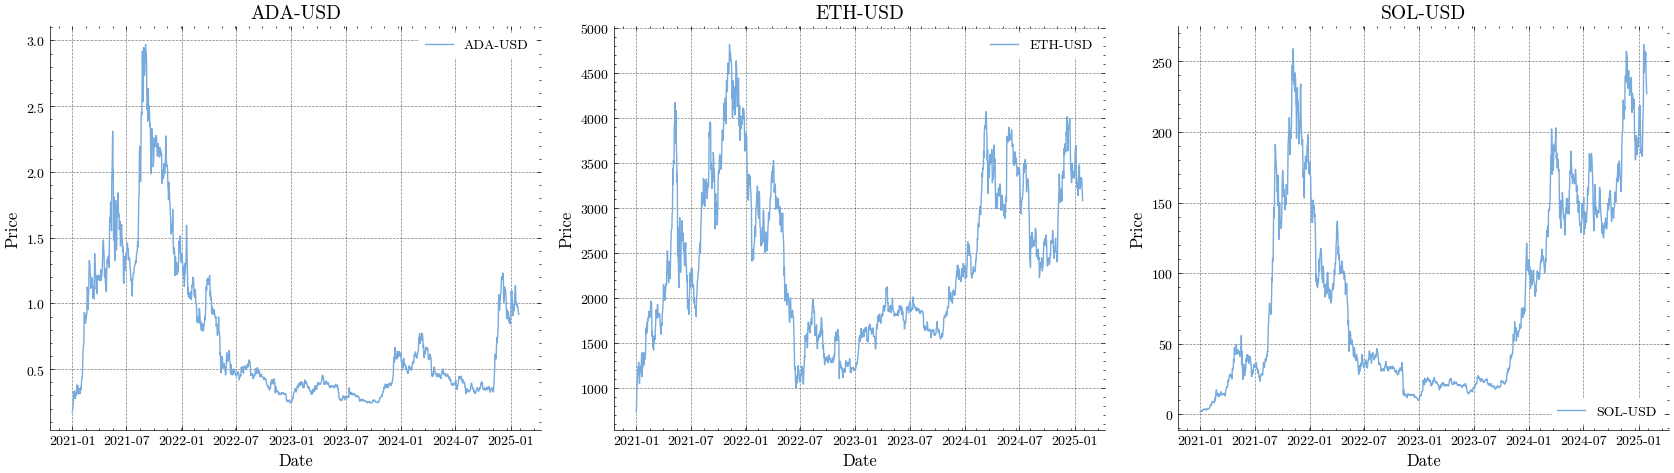

In [86]:
plt.figure(figsize=(17, 5))
for i, ticker in enumerate(TICKERS):
    plt.subplot(1, 3, i+1)
    plt.plot(data[ticker], label=ticker)
    plt.title(ticker)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.tight_layout()
plt.show()


In [87]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
df_scaled.head()


Ticker,ADA-USD,ETH-USD,SOL-USD
Date,,,
2021-01-01,0.000000,0.000000,0.000165
2021-01-02,0.000742,0.010821,0.000000
2021-01-03,0.010614,0.060058,0.001394
2021-01-04,0.017692,0.075915,0.002637
2021-01-05,0.029705,0.090560,0.001376


In [88]:
def create_sequences(data, seq_length):
    """Create sequences of past data points for time-series prediction."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [89]:
def split_data_time_based(df_scaled, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """Split the data into training, validation, and test sets based on time ranges."""
    n = len(df_scaled)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)
    
    train_data = df_scaled.iloc[:train_size]
    val_data = df_scaled.iloc[train_size:train_size + val_size]
    test_data = df_scaled.iloc[train_size + val_size:]
    
    seq_length = 60  # Using 60 days of historical data
    X_train, y_train = create_sequences(train_data.values, seq_length)
    X_val, y_val = create_sequences(val_data.values, seq_length)
    X_test, y_test = create_sequences(test_data.values, seq_length)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = split_data_time_based(df_scaled)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (982, 60, 3), y_train shape: (982, 3)
X_val shape: (237, 60, 3), y_val shape: (237, 3)
X_test shape: (90, 60, 3), y_test shape: (90, 3)


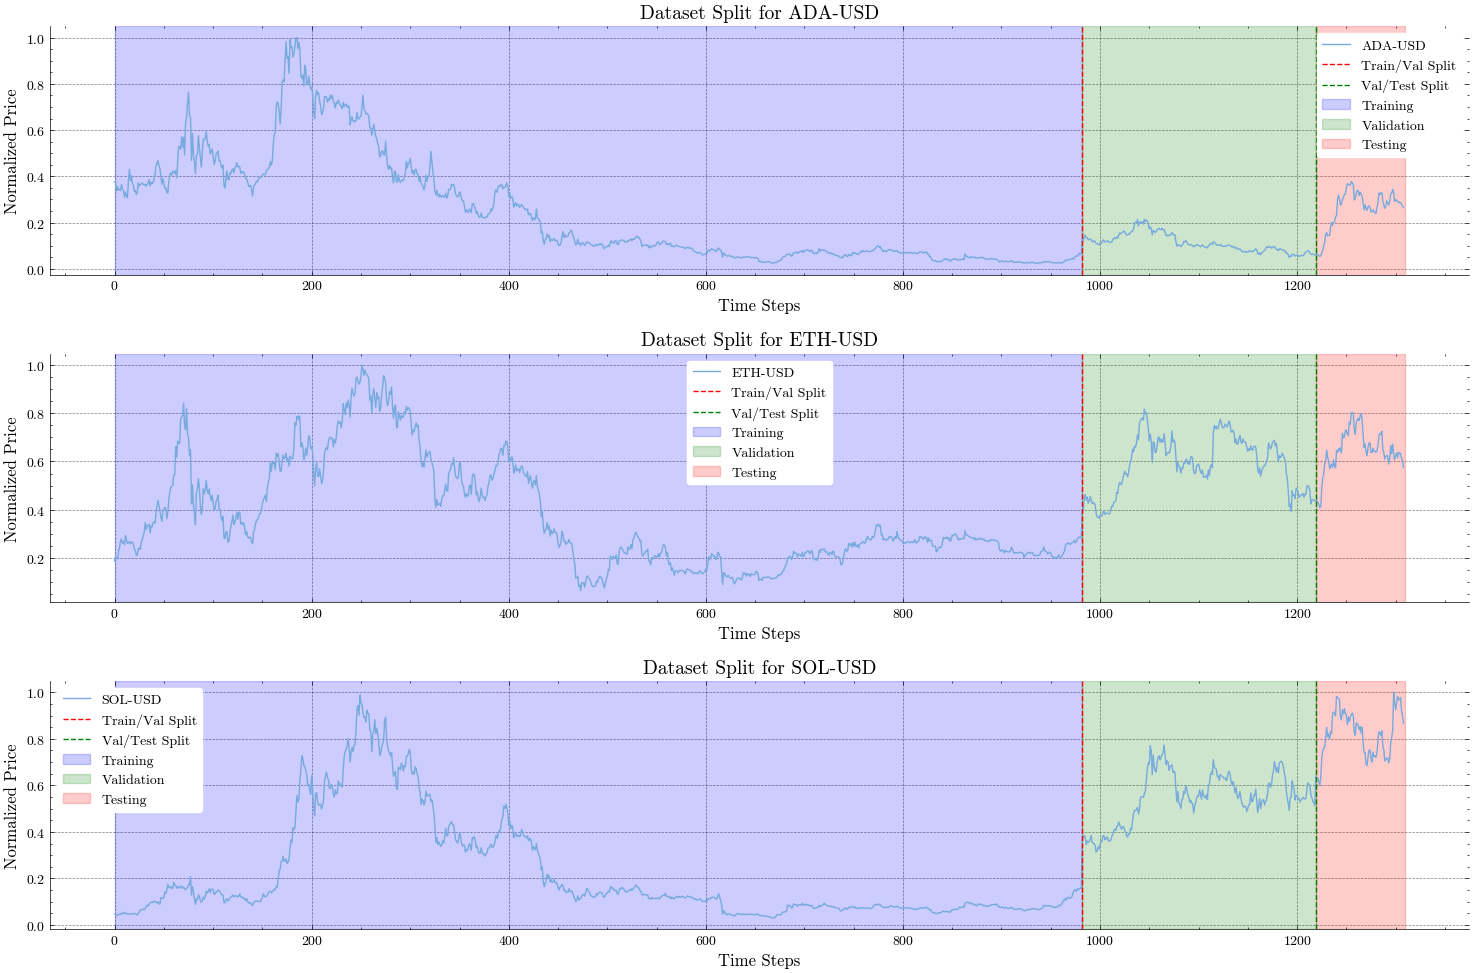

In [90]:
plt.figure(figsize=(15, 10))

train_end = len(X_train)
val_end = train_end + len(X_val)
total_len = train_end + len(X_val) + len(X_test)

for i in range(3):
    plt.subplot(3, 1, i+1)
    
    all_y = np.concatenate([y_train[:, i], y_val[:, i], y_test[:, i]])
    
    plt.plot(range(len(all_y)), all_y, label=['ADA-USD', 'ETH-USD', 'SOL-USD'][i])
    
    plt.axvline(x=train_end, color='r', linestyle='--', label='Train/Val Split')
    plt.axvline(x=val_end, color='g', linestyle='--', label='Val/Test Split')
    
    plt.axvspan(0, train_end, alpha=0.2, color='blue', label='Training')
    plt.axvspan(train_end, val_end, alpha=0.2, color='green', label='Validation')
    plt.axvspan(val_end, total_len, alpha=0.2, color='red', label='Testing')
    
    plt.title(f'Dataset Split for {["ADA-USD", "ETH-USD", "SOL-USD"][i]}')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()




DEEP NEURAL NETWORK MODELS (CNN, LSTM, CNN-LSTM, LSTM-CNN )


In [91]:
def build_cnn(params, input_shape):
    """Build and compile a CNN model with given parameters."""
    if hasattr(params, 'suggest_int'):
        filters1 = params.suggest_int('filters1', 16, 128)
        filters2 = params.suggest_int('filters2', 16, 128)
        kernel_size1 = params.suggest_int('kernel_size1', 2, 5)
        kernel_size2 = params.suggest_int('kernel_size2', 2, 5)
        pool_size = params.suggest_int('pool_size', 1, 3)
        dropout_rate = params.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = params.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    else:
        filters1 = int(params['filters1'])
        filters2 = int(params['filters2'])
        kernel_size1 = int(params['kernel_size1'])
        kernel_size2 = int(params['kernel_size2'])
        pool_size = int(params['pool_size'])
        dropout_rate = float(params['dropout_rate'])
        learning_rate = float(params['learning_rate'])
    
    model = Sequential([
        Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=pool_size, padding='same'),
        Dropout(dropout_rate),
        Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu', padding='same'),
        MaxPooling1D(pool_size=pool_size, padding='same'),
        Flatten(),
        Dense(units=1),
        LeakyReLU(alpha=0.1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [92]:
def build_lstm(params, input_shape):
    """Build and compile an LSTM model with given parameters."""
    if hasattr(params, 'suggest_int'):
        units1 = params.suggest_int('units1', 16, 128)
        units2 = params.suggest_int('units2', 8, 64)
        dropout_rate = params.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = params.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    else:
        units1 = int(params['units1'])
        units2 = int(params['units2'])
        dropout_rate = float(params['dropout_rate'])
        learning_rate = float(params['learning_rate'])
    
    model = Sequential([
        LSTM(units=units1, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units=units2),
        Dropout(dropout_rate),
        Dense(units=1),
        LeakyReLU(alpha=0.1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [93]:
def build_cnn_lstm(params, input_shape):
    """Build and compile a CNN-LSTM model with given parameters."""
    if hasattr(params, 'suggest_int'):
        filters = params.suggest_int('filters', 16, 128)
        kernel_size = params.suggest_int('kernel_size', 2, 5)
        pool_size = params.suggest_int('pool_size', 1, 3)
        lstm_units1 = params.suggest_int('lstm_units1', 16, 128)
        lstm_units2 = params.suggest_int('lstm_units2', 8, 64)
        dropout_rate = params.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = params.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    else:
        filters = int(params['filters'])
        kernel_size = int(params['kernel_size'])
        pool_size = int(params['pool_size'])
        lstm_units1 = int(params['lstm_units1'])
        lstm_units2 = int(params['lstm_units2'])
        dropout_rate = float(params['dropout_rate'])
        learning_rate = float(params['learning_rate'])
    
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=pool_size, padding='same'),
        Dropout(dropout_rate),
        Reshape((-1, filters)),
        LSTM(units=lstm_units1, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units=lstm_units2),
        Dropout(dropout_rate),
        Dense(units=1),
        LeakyReLU(alpha=0.1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


In [94]:
def build_lstm_cnn(params, input_shape):
    """Build and compile an LSTM-CNN model with given parameters."""
    if hasattr(params, 'suggest_int'):
        lstm_units1 = params.suggest_int('lstm_units1', 16, 128)
        lstm_units2 = params.suggest_int('lstm_units2', 8, 64)
        filters = params.suggest_int('filters', 16, 128)
        kernel_size = params.suggest_int('kernel_size', 2, 5)
        pool_size = params.suggest_int('pool_size', 1, 3)
        dropout_rate = params.suggest_float('dropout_rate', 0.1, 0.5)
        learning_rate = params.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    else:
        lstm_units1 = int(params['lstm_units1'])
        lstm_units2 = int(params['lstm_units2'])
        filters = int(params['filters'])
        kernel_size = int(params['kernel_size'])
        pool_size = int(params['pool_size'])
        dropout_rate = float(params['dropout_rate'])
        learning_rate = float(params['learning_rate'])
    
    model = Sequential([
        LSTM(units=lstm_units1, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units=lstm_units2, return_sequences=True),
        Dropout(dropout_rate),
        Reshape((-1, lstm_units2)),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPooling1D(pool_size=pool_size, padding='same'),
        Dropout(dropout_rate),
        Flatten(),
        Dense(units=1),
        LeakyReLU(alpha=0.1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [95]:
def objective(trial, model_type, X_train, y_train, X_val, y_val, batch_sizes=None, epoch_range=None):
    """
    Objective function for Optuna optimization.

    Args:
        trial (optuna.Trial): Optuna trial object.
        model_type (str): Type of model to optimize (e.g., 'CNN', 'LSTM').
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        X_val (np.array): Validation features.
        y_val (np.array): Validation labels.
        batch_sizes (list): List of batch sizes to try. Defaults to [16, 32, 64, 128].
        epoch_range (tuple): Range of epochs to try. Defaults to (100, 200).

    Returns:
        float: Validation loss (primary metric for optimization).
    """
    # Default hyperparameter ranges
    if batch_sizes is None:
        batch_sizes = [16, 32, 64, 128]
    if epoch_range is None:
        epoch_range = (100, 200)

    batch_size = trial.suggest_categorical('batch_size', batch_sizes)
    epochs = trial.suggest_int('epochs', epoch_range[0], epoch_range[1], step=10)

    input_shape = (X_train.shape[1], X_train.shape[2])
    if model_type == 'CNN':
        model = build_cnn(trial, input_shape)
    elif model_type == 'LSTM':
        model = build_lstm(trial, input_shape)
    elif model_type == 'CNN-LSTM':
        model = build_cnn_lstm(trial, input_shape)
    elif model_type == 'LSTM-CNN':
        model = build_lstm_cnn(trial, input_shape)
    else:
        raise ValueError(f"Invalid model type: {model_type}. Supported types are 'CNN', 'LSTM', 'CNN-LSTM', 'LSTM-CNN'.")

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=[early_stopping]
        )
    except Exception as e:
        return float('inf') 
    y_pred = model.predict(X_val, verbose=0)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    trial.set_user_attr("mse", mse)
    trial.set_user_attr("mae", mae)
    trial.set_user_attr("r2", r2)

    val_loss = min(history.history['val_loss'])
    return val_loss



In [96]:
database_url = 'sqlite:///master.db'

In [97]:
def optimize_hyperparameters(ticker, model_type, X_train, y_train, X_val, y_val, n_trials=15, batch_sizes=None, epoch_range=None, n_jobs=1):
    """
    Optimize hyperparameters using Optuna with SQLite backend.
    """
    study = optuna.create_study(
        direction='minimize',
        study_name=f'{ticker}_{model_type}_study',
        storage=database_url,
        load_if_exists=True
    )

    study.optimize(
        lambda trial: objective(trial, model_type, X_train, y_train, X_val, y_val, batch_sizes, epoch_range),
        n_trials=n_trials,
        n_jobs=n_jobs
    )

    trials_df = study.trials_dataframe()
    
    metrics = ['mse', 'mae', 'r2']
    for metric in metrics:
        trials_df[metric] = [
            t.user_attrs.get(metric, None) if hasattr(t, 'user_attrs') else None
            for t in study.trials
        ]

    os.makedirs('data', exist_ok=True)
    
    csv_filename = os.path.join('data', f'{ticker}_{model_type}_optimization_results.csv')
    trials_df.to_csv(csv_filename, index=False)

    return study.best_params

In [98]:
def run_optimization(ticker, model_type, X_train, y_train, X_val, y_val, n_trials=15, batch_sizes=None, epoch_range=None, n_jobs=1):
    """
    Run optimization for a specific ticker and model type.

    Args:
        ticker (str): Identifier for the dataset or task.
        model_type (str): Type of model to optimize.
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        X_val (np.array): Validation features.
        y_val (np.array): Validation labels.
        n_trials (int): Number of optimization trials. Defaults to 15.
        batch_sizes (list): List of batch sizes to try. Defaults to [16, 32, 64, 128].
        epoch_range (tuple): Range of epochs to try. Defaults to (100, 200).
        n_jobs (int): Number of parallel jobs. Defaults to 1.

    Returns:
        dict: Best hyperparameters found.
    """
    best_params = optimize_hyperparameters(
        ticker, model_type, X_train, y_train, X_val, y_val,
        n_trials=n_trials, batch_sizes=batch_sizes, epoch_range=epoch_range, n_jobs=n_jobs
    )
    return best_params

In [99]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def load_optimization_results():
    """
    Load all optimization results from CSV files into a single DataFrame.
    """
    csv_files = glob.glob(os.path.join('data', '*_optimization_results.csv'))
    
    if not csv_files:
        print("No optimization results found. Running new optimization...")
        return None
    
    print(f"Found {len(csv_files)} optimization result files. Loading and visualizing...")
    
    all_results = []
    for file in csv_files:
        filename = os.path.basename(file)
        ticker, model_type = filename.replace('_optimization_results.csv', '').split('_')
        df = pd.read_csv(file)
        df['ticker'] = ticker
        df['model_type'] = model_type
        all_results.append(df)
    
    return pd.concat(all_results, ignore_index=True)

def plot_hyperparameter_vs_performance(results_df):
    """
    Plot scatterplots of hyperparameters vs. performance metrics.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hyperparameter Impact on Model Performance', fontsize=16, y=1.02)
    
    # Plot 1: Batch Size vs. R²
    sns.scatterplot(x='params_batch_size', y='r2', hue='model_type', data=results_df, ax=axes[0, 0])
    axes[0, 0].set_title('Batch Size vs. R²')
    axes[0, 0].set_xlabel('Batch Size')
    axes[0, 0].set_ylabel('R² Score')
    
    # Plot 2: Dropout Rate vs. R²
    sns.scatterplot(x='params_dropout_rate', y='r2', hue='model_type', data=results_df, ax=axes[0, 1])
    axes[0, 1].set_title('Dropout Rate vs. R²')
    axes[0, 1].set_xlabel('Dropout Rate')
    axes[0, 1].set_ylabel('R² Score')
    
    # Plot 3: Learning Rate vs. R²
    sns.scatterplot(x='params_learning_rate', y='r2', hue='model_type', data=results_df, ax=axes[1, 0])
    axes[1, 0].set_title('Learning Rate vs. R²')
    axes[1, 0].set_xlabel('Learning Rate')
    axes[1, 0].set_ylabel('R² Score')
    
    # Plot 4: Epochs vs. R²
    sns.scatterplot(x='params_epochs', y='r2', hue='model_type', data=results_df, ax=axes[1, 1])
    axes[1, 1].set_title('Epochs vs. R²')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('R² Score')
    
    plt.tight_layout()
    plt.show()

def plot_hyperparameter_distributions(results_df):
    """
    Plot distributions of hyperparameters.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Hyperparameter Distributions', fontsize=16, y=1.02)
    
    # Plot 1: Batch Size Distribution
    sns.histplot(results_df['params_batch_size'], bins=20, kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Batch Size Distribution')
    axes[0, 0].set_xlabel('Batch Size')
    axes[0, 0].set_ylabel('Frequency')
    
    # Plot 2: Dropout Rate Distribution
    sns.histplot(results_df['params_dropout_rate'], bins=20, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Dropout Rate Distribution')
    axes[0, 1].set_xlabel('Dropout Rate')
    axes[0, 1].set_ylabel('Frequency')
    
    # Plot 3: Learning Rate Distribution
    sns.histplot(results_df['params_learning_rate'], bins=20, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Learning Rate Distribution')
    axes[1, 0].set_xlabel('Learning Rate')
    axes[1, 0].set_ylabel('Frequency')
    
    # Plot 4: Epochs Distribution
    sns.histplot(results_df['params_epochs'], bins=20, kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Epochs Distribution')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

def plot_model_performance(results_df):
    """
    Plot model performance comparisons.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Model Performance Comparison', fontsize=16, y=1.02)
    
    # Plot 1: R² Scores by Model Type
    sns.boxplot(x='model_type', y='r2', data=results_df, ax=axes[0])
    axes[0].set_title('R² Scores by Model Type')
    axes[0].set_xlabel('Model Type')
    axes[0].set_ylabel('R² Score')
    
    # Plot 2: MSE Scores by Model Type
    sns.boxplot(x='model_type', y='mse', data=results_df, ax=axes[1])
    axes[1].set_title('MSE Scores by Model Type')
    axes[1].set_xlabel('Model Type')
    axes[1].set_ylabel('MSE')
    
    plt.tight_layout()
    plt.show()

def plot_performance_over_time(results_df):
    """
    Plot performance metrics over time.
    """
    results_df['datetime_start'] = pd.to_datetime(results_df['datetime_start'])
    results_df.sort_values('datetime_start', inplace=True)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('Performance Over Time', fontsize=16, y=1.02)
    
    # Plot 1: R² Over Time
    sns.lineplot(x='datetime_start', y='r2', hue='model_type', data=results_df, ax=axes[0])
    axes[0].set_title('R² Scores Over Time')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('R² Score')
    
    # Plot 2: MSE Over Time
    sns.lineplot(x='datetime_start', y='mse', hue='model_type', data=results_df, ax=axes[1])
    axes[1].set_title('MSE Scores Over Time')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('MSE')
    
    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(results_df):
    """
    Plot a correlation heatmap for hyperparameters and performance metrics.
    """
    numerical_cols = results_df.select_dtypes(include=['float64', 'int64'])
    correlation_matrix = numerical_cols.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Hyperparameters and Performance Metrics')
    plt.tight_layout()
    plt.show()

def plot_best_r2_scores(results_df):
    """
    Plot a bar chart showing the best R² scores for each model type across tickers.
    Highlight the best-performing model for each ticker.
    """
    # Find the best R² score for each model type and ticker
    best_r2_scores = results_df.groupby(['ticker', 'model_type'])['r2'].max().reset_index()
    
    # Find the best model for each ticker
    best_models = best_r2_scores.loc[best_r2_scores.groupby('ticker')['r2'].idxmax()]
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='ticker', y='r2', hue='model_type', data=best_r2_scores, palette='viridis')
    plt.title('Best R² Scores by Ticker and Model Type')
    plt.xlabel('Ticker')
    plt.ylabel('Best R² Score')
    plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Annotate the best-performing model for each ticker
    for index, row in best_models.iterrows():
        ax.text(row.name, row['r2'], f'{row["model_type"]}\n{row["r2"]:.4f}', 
                ha='center', va='bottom', fontsize=9, color='red')
    
    plt.tight_layout()
    plt.show()


def check_and_visualize_optuna_results():
    """
    Check for existing Optuna results and visualize them if they exist.
    If no results exist, return False to indicate optimization needs to be run.
    """
    results_df = load_optimization_results()
    
    if results_df is None:
        return False, None
    
    # Create visualizations
    plot_hyperparameter_vs_performance(results_df)
    plot_hyperparameter_distributions(results_df)
    plot_model_performance(results_df)
    plot_performance_over_time(results_df)
    plot_correlation_heatmap(results_df)
    plot_best_r2_scores(results_df)
    
    return True, results_df

Found 12 optimization result files. Loading and visualizing...


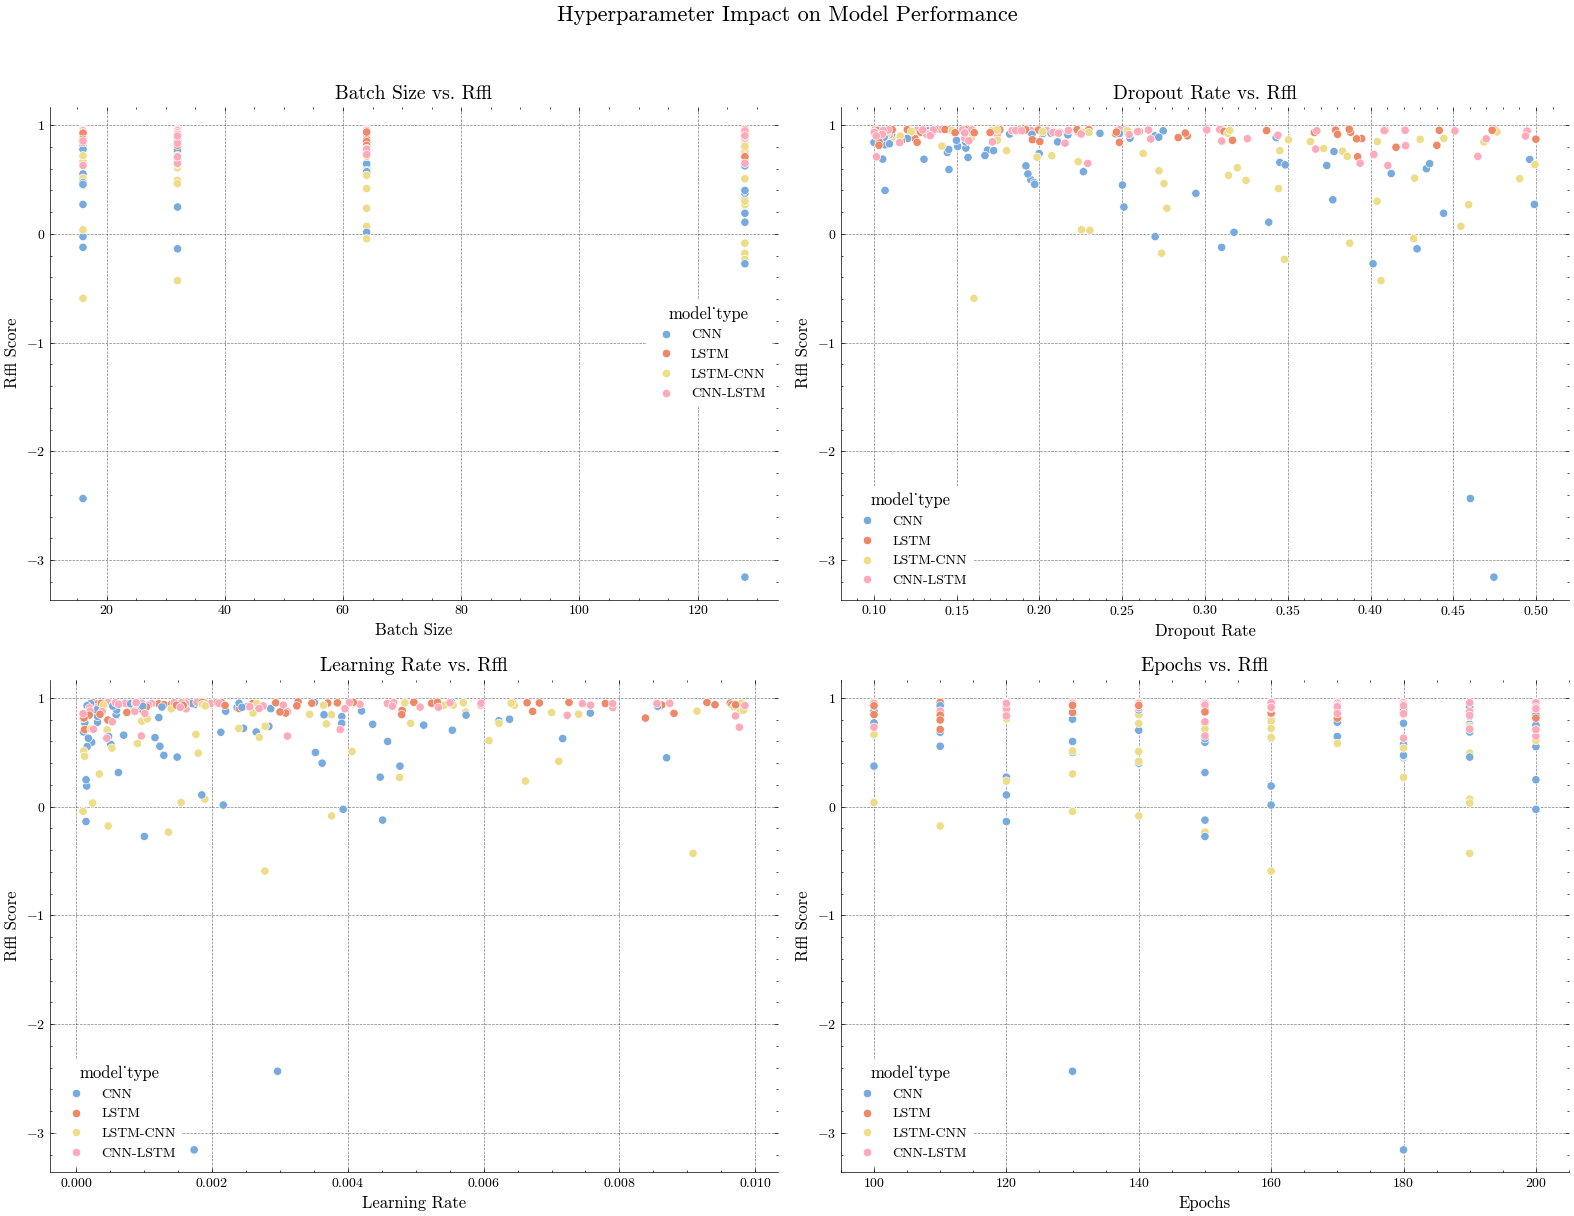

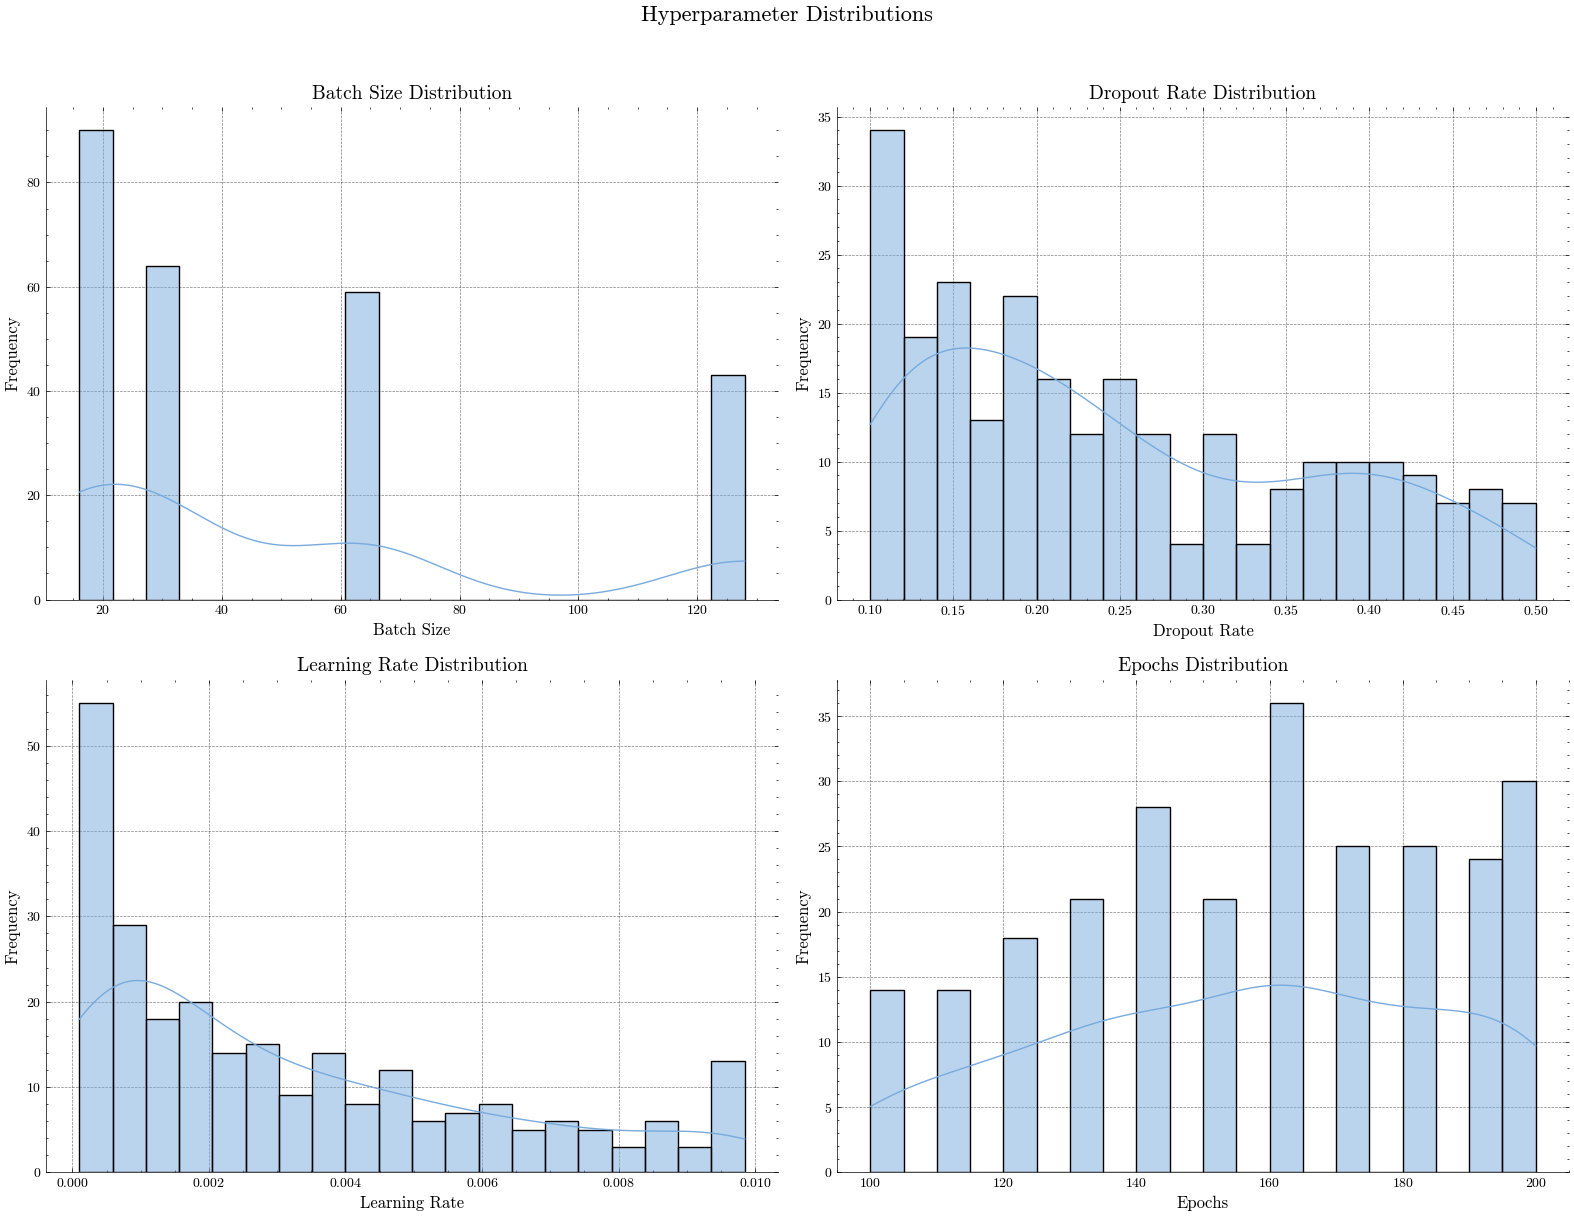

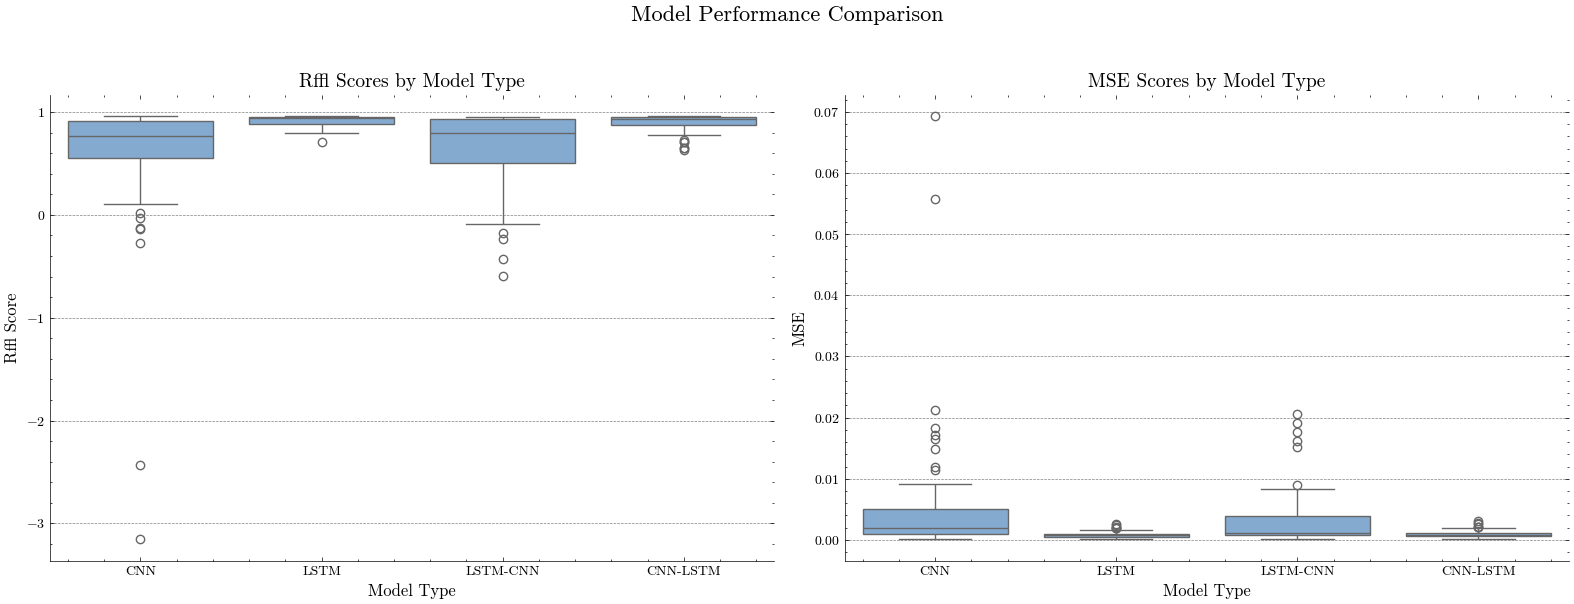

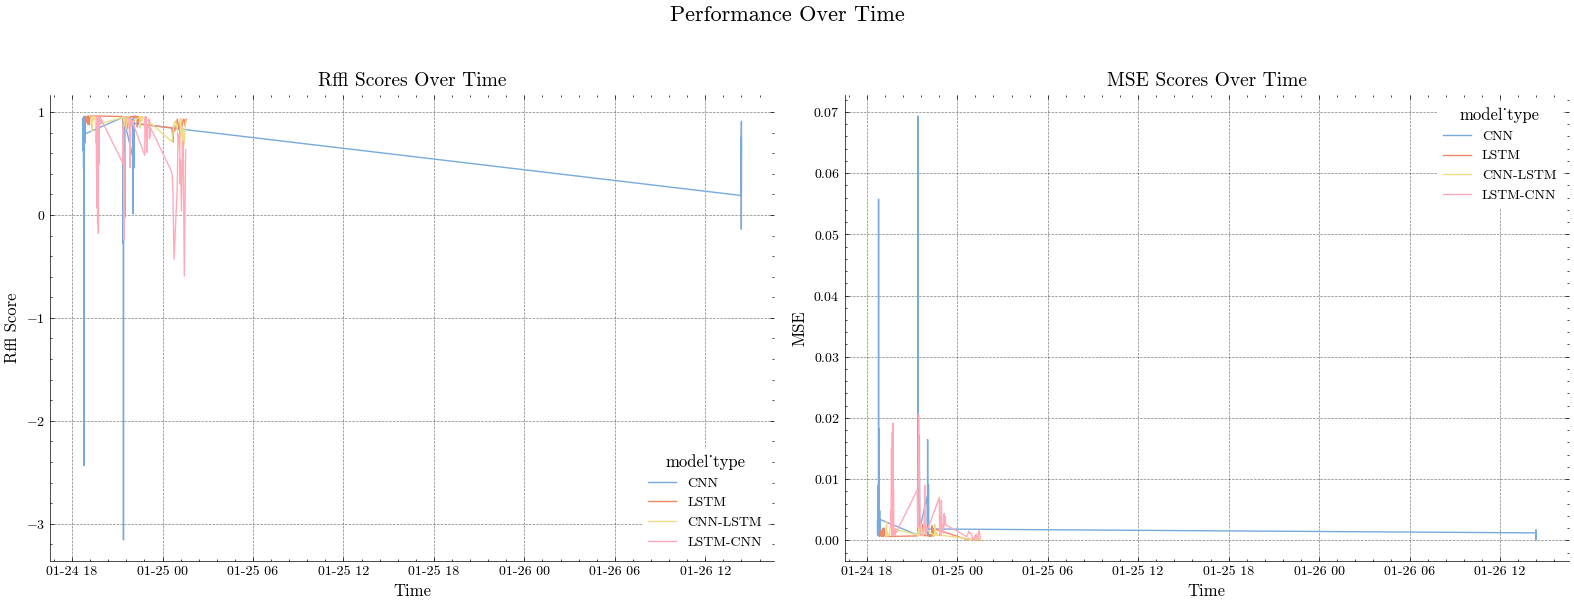

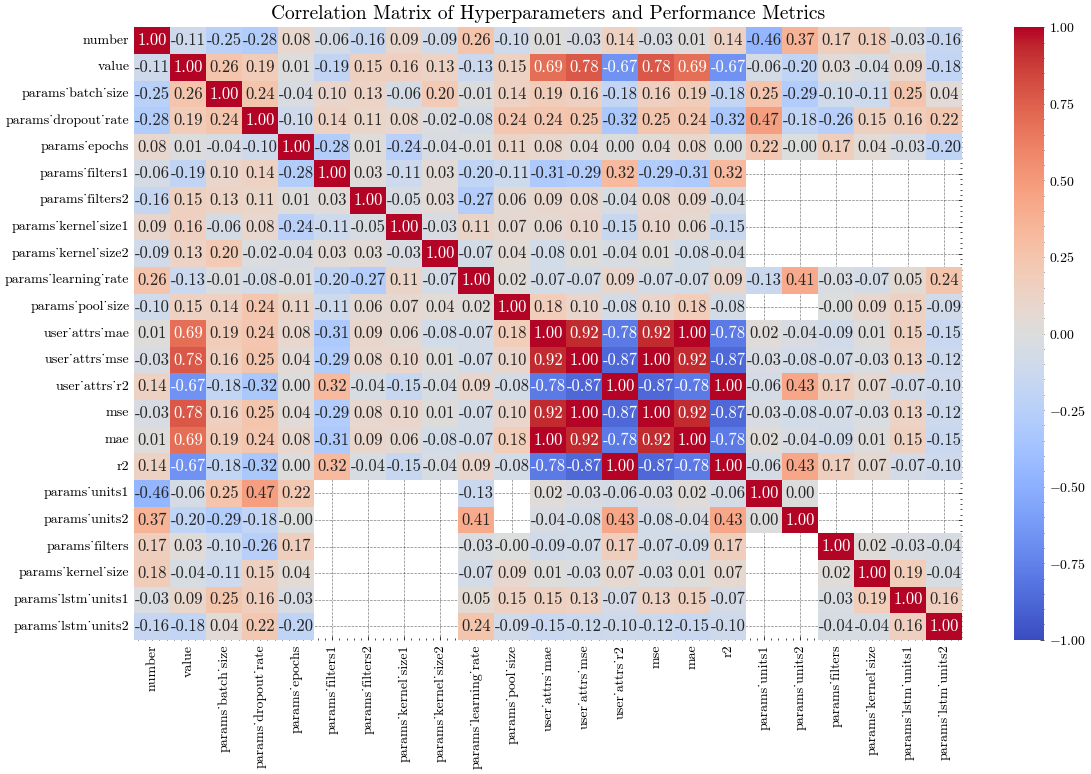

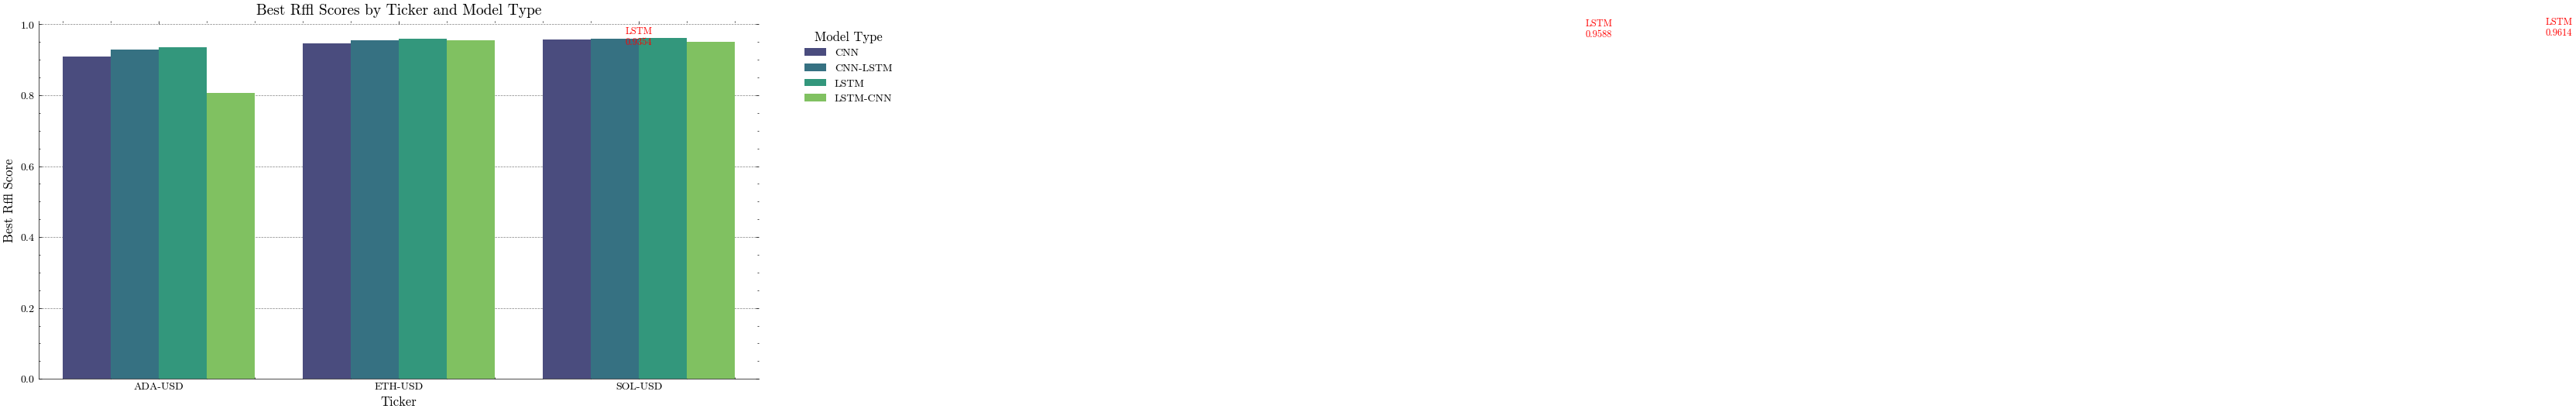

In [100]:
results_exist, results_df = check_and_visualize_optuna_results()


if not results_exist:
    for ticker in TICKERS:
        ticker_idx = TICKERS.index(ticker)
        y_train_ticker = y_train[:, ticker_idx:ticker_idx+1]
        y_val_ticker = y_val[:, ticker_idx:ticker_idx+1]
        
        for model_type in MODEL_TYPES:
            print(f"\nOptimizing {model_type} for {ticker}...")
            best_params = run_optimization(
                ticker=ticker,
                model_type=model_type,
                X_train=X_train,
                y_train=y_train_ticker,
                X_val=X_val,
                y_val=y_val_ticker,
                n_trials=15,
                n_jobs=-1  # Use all available cores
            )
            print(f"Best parameters for {ticker} {model_type}:", best_params)

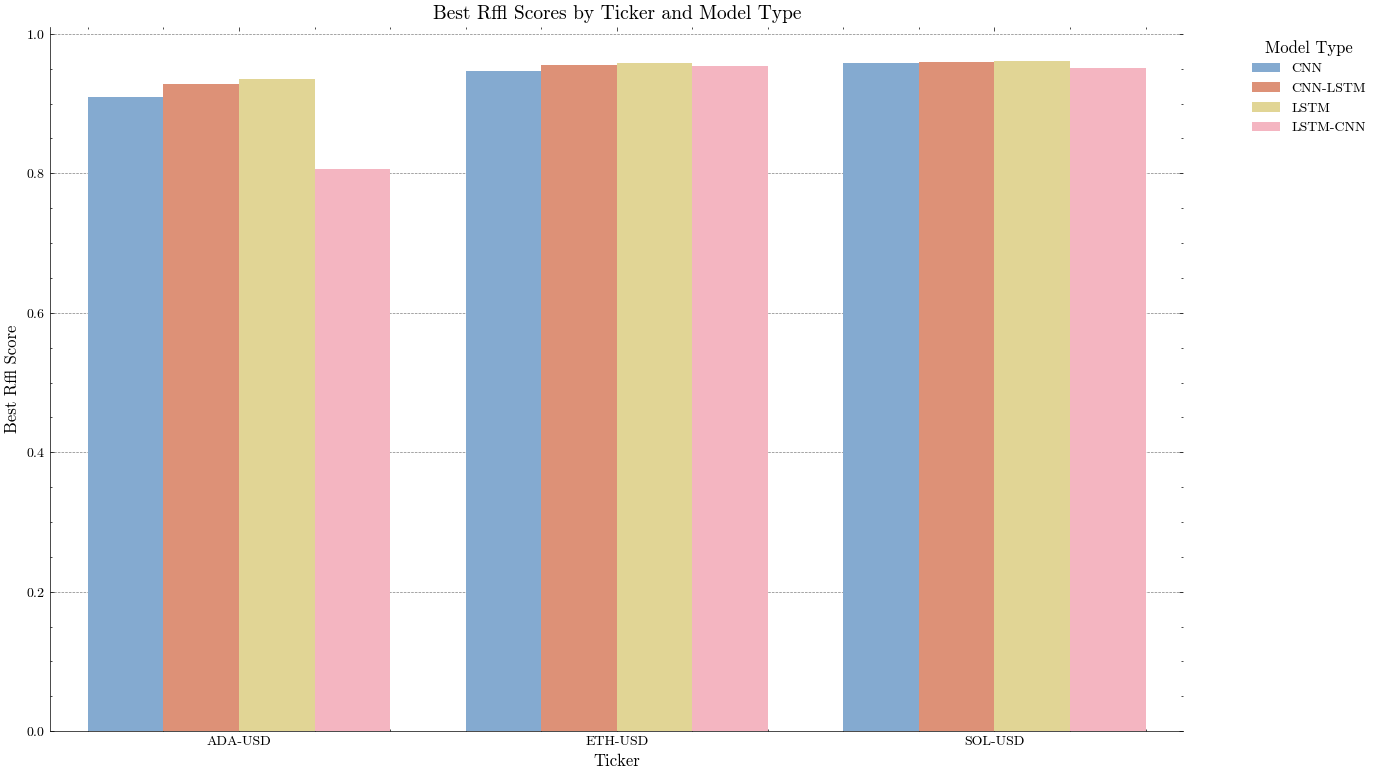

Best Hyperparameters for Each Ticker and Model Type:
      ticker model_type        r2  params_batch_size  params_dropout_rate  \
12   ADA-USD        CNN  0.909701                 16             0.217210   
248  ADA-USD   CNN-LSTM  0.928100                 32             0.154871   
219  ADA-USD       LSTM  0.935444                 64             0.246552   
233  ADA-USD   LSTM-CNN  0.805649                128             0.141136   
151  ETH-USD        CNN  0.947071                 64             0.274787   
194  ETH-USD   CNN-LSTM  0.955228                 32             0.159171   
107  ETH-USD       LSTM  0.958755                 16             0.136803   
138  ETH-USD   LSTM-CNN  0.954383                 64             0.174311   
73   SOL-USD        CNN  0.958234                128             0.144585   
81   SOL-USD   CNN-LSTM  0.959641                 32             0.140279   
29   SOL-USD       LSTM  0.961354                 64             0.387155   
37   SOL-USD   LSTM-CNN

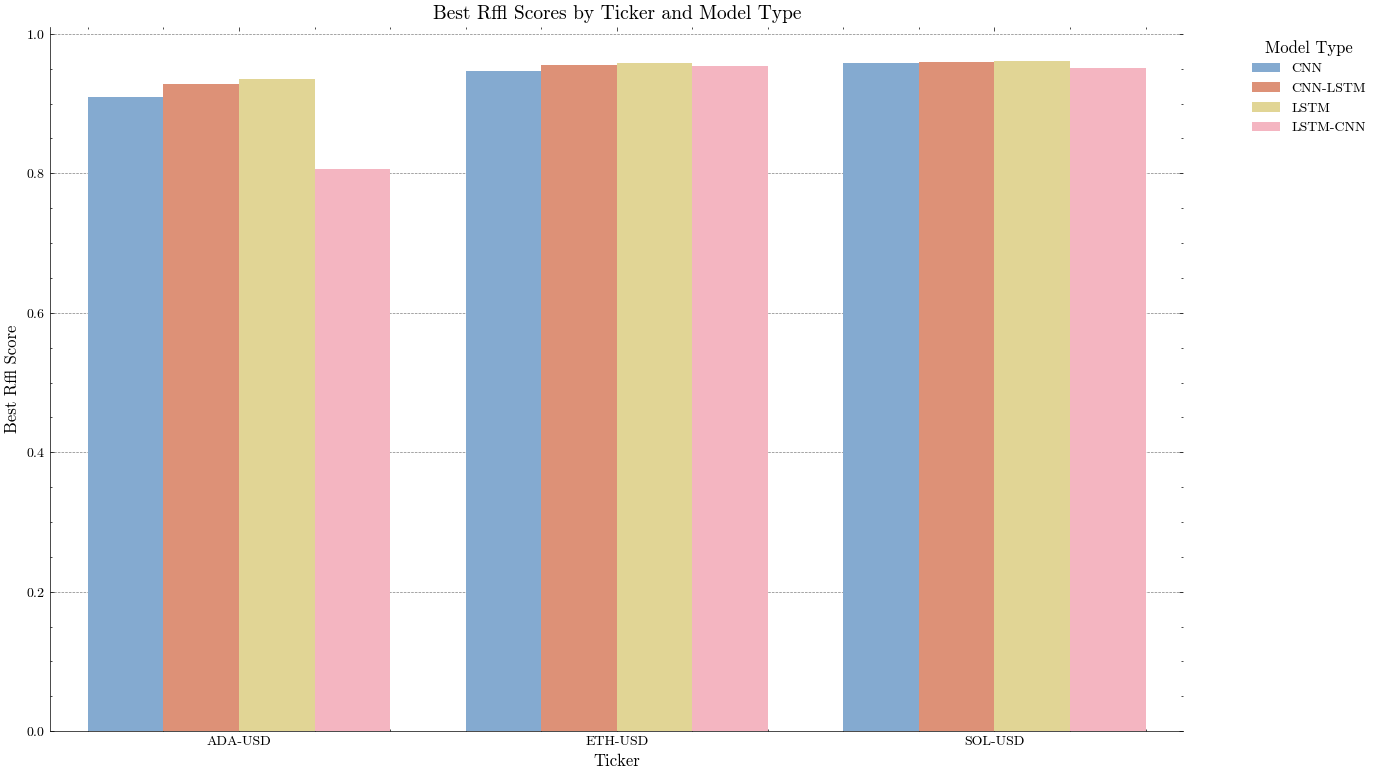

Best Hyperparameters for Each Ticker and Model Type:
      ticker model_type        r2  params_batch_size  params_dropout_rate  \
12   ADA-USD        CNN  0.909701                 16             0.217210   
248  ADA-USD   CNN-LSTM  0.928100                 32             0.154871   
219  ADA-USD       LSTM  0.935444                 64             0.246552   
233  ADA-USD   LSTM-CNN  0.805649                128             0.141136   
151  ETH-USD        CNN  0.947071                 64             0.274787   
194  ETH-USD   CNN-LSTM  0.955228                 32             0.159171   
107  ETH-USD       LSTM  0.958755                 16             0.136803   
138  ETH-USD   LSTM-CNN  0.954383                 64             0.174311   
73   SOL-USD        CNN  0.958234                128             0.144585   
81   SOL-USD   CNN-LSTM  0.959641                 32             0.140279   
29   SOL-USD       LSTM  0.961354                 64             0.387155   
37   SOL-USD   LSTM-CNN

(True,
      number     value              datetime_start           datetime_complete  \
 0         0  0.001226  2025-01-26 14:23:20.518470  2025-01-26 14:23:39.722850   
 1         1  0.000618  2025-01-26 14:23:20.540955  2025-01-26 14:23:41.541093   
 2         2  0.000520  2025-01-26 14:23:20.557277  2025-01-26 14:23:48.893209   
 3         3  0.000474  2025-01-26 14:23:20.571221  2025-01-26 14:23:49.353083   
 4         4  0.000397  2025-01-26 14:23:20.522183  2025-01-26 14:23:41.817574   
 ..      ...       ...                         ...                         ...   
 251      11  0.000104  2025-01-25 01:20:11.468171  2025-01-25 01:22:17.956870   
 252      12  0.000077  2025-01-25 01:22:17.984207  2025-01-25 01:26:24.334185   
 253      13  0.000072  2025-01-25 01:26:24.357418  2025-01-25 01:31:28.405416   
 254      14  0.000073  2025-01-25 01:31:28.445808  2025-01-25 01:36:26.698138   
 255      15  0.000080  2025-01-25 01:36:26.714481  2025-01-25 01:38:04.985171   
 
       

In [101]:
def get_best_hyperparameters(results_df):
    """
    Extract the hyperparameters for the best-performing models (based on R² score)
    for each ticker and model type.
    """
    # Group by ticker and model type, then find the row with the maximum R² score
    best_models = results_df.loc[results_df.groupby(['ticker', 'model_type'])['r2'].idxmax()]
    
    # Select relevant columns (ticker, model_type, r2, and hyperparameters)
    hyperparameter_columns = [
        'params_batch_size', 'params_dropout_rate', 'params_learning_rate', 
        'params_epochs', 'params_filters1', 'params_filters2', 
        'params_kernel_size1', 'params_kernel_size2', 'params_pool_size'
    ]
    best_hyperparameters = best_models[['ticker', 'model_type', 'r2'] + hyperparameter_columns]
    
    return best_hyperparameters

def visualize_best_hyperparameters(best_hyperparameters):
    """
    Visualize the best hyperparameters for each ticker and model type.
    """
    # Plot hyperparameters for the best models
    plt.figure(figsize=(14, 8))
    sns.barplot(x='ticker', y='r2', hue='model_type', data=best_hyperparameters)
    plt.title('Best R² Scores by Ticker and Model Type')
    plt.xlabel('Ticker')
    plt.ylabel('Best R² Score')
    plt.legend(title='Model Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Display the best hyperparameters in a table
    print("Best Hyperparameters for Each Ticker and Model Type:")
    print(best_hyperparameters)

def check_and_visualize_optuna_results():
    """
    Check for existing Optuna results and visualize them if they exist.
    If no results exist, return False to indicate optimization needs to be run.
    """
    results_df = load_optimization_results()
    
    if results_df is None:
        return False, None
    
    # Get the best hyperparameters
    best_hyperparameters = get_best_hyperparameters(results_df)
    
    # Visualize the best hyperparameters
    visualize_best_hyperparameters(best_hyperparameters)
    
    return True, results_df

best_hyperparameters = get_best_hyperparameters(results_df)
visualize_best_hyperparameters(best_hyperparameters)
check_and_visualize_optuna_results()



In [102]:
# load all the csv files from data folder
import os 
import glob
import pandas as pd


data_folder = "data"

# Automatically list all CSV files in the directory
file_list = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# Load all CSVs into a dictionary of DataFrames
dfs = {}
for filename in file_list:
    path = os.path.join(data_folder, filename)
    df = pd.read_csv(path)
    parts = filename.replace("_optimization_results.csv", "").split("-")
    ticker = parts[0]
    model = "-".join(parts[1:])
    df['Ticker'] = ticker  # Add Ticker column
    df['Model'] = model  # Add Model column
    dfs[filename] = df

# Merge all DataFrames
merged_df = pd.concat(dfs.values(), ignore_index=True)

# Display the merged DataFrame
# Display summary statistics
print("Summary Statistics:")
print(merged_df.describe())


Summary Statistics:
           number       value  params_batch_size  params_dropout_rate  \
count  256.000000  255.000000         256.000000           256.000000   
mean    12.011719    0.001206          49.875000             0.250706   
std      8.217381    0.002862          39.504182             0.117481   
min      0.000000    0.000065          16.000000             0.100089   
25%      5.000000    0.000630          16.000000             0.152770   
50%     11.000000    0.000708          32.000000             0.222952   
75%     17.250000    0.000818          64.000000             0.345923   
max     30.000000    0.037753         128.000000             0.499909   

       params_epochs  params_filters1  params_filters2  params_kernel_size1  \
count     256.000000        75.000000        75.000000            75.000000   
mean      156.132812        75.760000        67.253333             3.453333   
std        29.682733        30.225209        31.629226             0.990404   
min   

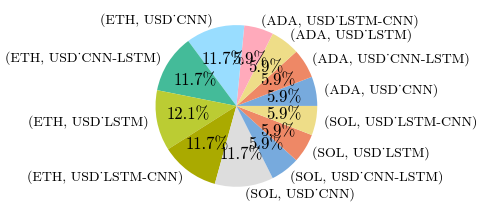

In [103]:
import matplotlib.pyplot as plt
# create pie plot for the ticker and model 
merged_df.groupby(['Ticker', 'Model']).size().plot(kind='pie', autopct='%1.1f%%')
plt.show()



In [104]:
# Create a function that gets the best hyperparameters for each ticker and model type based on r2 score
def get_best_hyperparameters(merged_df):
    # Get indices of rows with highest r2 score for each ticker/model combination
    idx = merged_df.groupby(['Ticker', 'Model'])['r2'].idxmax()
    
    # Get the full rows with hyperparameters using those indices
    best_results = merged_df.loc[idx]
    
    # Get hyperparameter columns based on column names containing 'params_'
    param_cols = [col for col in merged_df.columns if 'params_' in col]
    
    # Select relevant columns to display
    cols_to_show = ['Ticker', 'Model', 'r2'] + param_cols
    
    return best_results[cols_to_show]

# Get and display best hyperparameters
best_hyperparameters = get_best_hyperparameters(merged_df)
print("\nBest hyperparameters for each ticker and model type:")
print(best_hyperparameters.to_string())



Best hyperparameters for each ticker and model type:
    Ticker         Model        r2  params_batch_size  params_dropout_rate  params_epochs  params_filters1  params_filters2  params_kernel_size1  params_kernel_size2  params_learning_rate  params_pool_size  params_units1  params_units2  params_filters  params_kernel_size  params_lstm_units1  params_lstm_units2
12     ADA       USD_CNN  0.909701                 16             0.217210            190            121.0             35.0                  3.0                  3.0              0.002371               3.0            NaN            NaN             NaN                 NaN                 NaN                 NaN
248    ADA  USD_CNN-LSTM  0.928100                 32             0.154871            180              NaN              NaN                  NaN                  NaN              0.009848               1.0            NaN            NaN           115.0                 2.0               108.0                41.0
219    ADA

In [105]:
def get_best_hyperparameters_for_models(merged_df):
    model_metrics = merged_df.groupby('Model').agg({
        'r2': ['mean', 'std'],
        'mse': ['mean', 'std'],
        'mae': ['mean', 'std']
    })
    
    best_params = {}
    for model in merged_df['Model'].unique():
        model_df = merged_df[merged_df['Model'] == model]
        param_cols = [col for col in model_df.columns if 'params_' in col]
        
        best_row = model_df.loc[model_df['r2'].idxmax()]
        
        best_params[model] = {
            'parameters': {col: best_row[col] for col in param_cols if not pd.isna(best_row[col])},
            'r2_score': best_row['r2'],
            'mse': best_row['mse'],
            'mae': best_row['mae'],
            'ticker': best_row['Ticker']
        }

    print("Model Performance Summary:")
    print("-------------------------")
    print(model_metrics)
    print("\nBest Parameters per Model:")
    print("-------------------------")
    for model, params in best_params.items():
        print(f"\n{model}:")
        print(f"Best performance achieved on {params['ticker']}")
        print(f"R2 Score: {params['r2_score']:.4f}")
        print(f"MSE: {params['mse']:.6f}")
        print(f"MAE: {params['mae']:.6f}")
        print("Parameters:")
        for param, value in params['parameters'].items():
            print(f"  {param.replace('params_', '')}: {value}")

best_hyperparameters_for_models = get_best_hyperparameters_for_models(merged_df)

Model Performance Summary:
-------------------------
                    r2                 mse                 mae          
                  mean       std      mean       std      mean       std
Model                                                                   
USD_CNN       0.586552  0.639188  0.005369  0.010624  0.051680  0.043698
USD_CNN-LSTM  0.894896  0.083898  0.000952  0.000668  0.022004  0.008878
USD_LSTM      0.917679  0.052431  0.000823  0.000586  0.020083  0.008599
USD_LSTM-CNN  0.634515  0.392429  0.003467  0.004886  0.042133  0.031480

Best Parameters per Model:
-------------------------

USD_CNN:
Best performance achieved on SOL
R2 Score: 0.9582
MSE: 0.000678
MAE: 0.019855
Parameters:
  batch_size: 128
  dropout_rate: 0.1445848918561144
  epochs: 150
  filters1: 74.0
  filters2: 54.0
  kernel_size1: 3.0
  kernel_size2: 5.0
  learning_rate: 0.0055285481252812
  pool_size: 2.0

USD_LSTM:
Best performance achieved on SOL
R2 Score: 0.9614
MSE: 0.000627
MAE: 0.018803